Importing the stocks dataset, indexing the dates , dealing with missing values and setting the timestamp of trading.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

amzn = pd.read_csv(r"D:\Project QUANT\AMZN_1min.txt", header=None)
adbe = pd.read_csv(r"D:\Project QUANT\ADBE_1min.txt", header=None)

def organize_data(data_frame):
    start_time = pd.to_datetime('09:30:00').time()
    end_time = pd.to_datetime('16:00:00').time()
    
    timestamps = pd.date_range(start=data_frame.index.min().replace(hour=start_time.hour, minute=start_time.minute),
                                        end=data_frame.index.max().replace(hour=end_time.hour, minute=end_time.minute),
                                        freq='T')
    
    timestamps = timestamps[(timestamps.dayofweek < 5) &
                                              (timestamps.time >= start_time) &
                                              (timestamps.time <= end_time)]
    
    data_frame = data_frame.reindex(timestamps)
    
    data_frame.interpolate(method='linear', inplace=True)
    
    return data_frame

stocks = [amzn, adbe]

for i, stock_data in enumerate(stocks):
    stock_data.columns = ['Time', 'open', 'high', 'low', 'close', 'volume']
    stock_data['Time'] = pd.to_datetime(stock_data['Time'])
    stock_data.set_index('Time', inplace=True)  
    stocks[i] = organize_data(stock_data)


In [4]:
print(stocks[0].head())
print(stocks[1].head())

                      open   high    low  close    volume
2005-01-03 09:30:00  44.95  45.15  44.91  45.11  167005.0
2005-01-03 09:31:00  45.11  45.15  45.00  45.10   73739.0
2005-01-03 09:32:00  45.10  45.15  45.03  45.09   75816.0
2005-01-03 09:33:00  45.08  45.11  45.03  45.11  115016.0
2005-01-03 09:34:00  45.11  45.19  45.08  45.09   86538.0
                        open     high      low    close    volume
2005-01-03 09:30:00  31.4943  31.6143  31.3893  31.4943  475832.0
2005-01-03 09:31:00  31.4893  31.5343  31.3993  31.5293   45354.0
2005-01-03 09:32:00  31.5293  31.5543  31.5093  31.5443   13110.0
2005-01-03 09:33:00  31.5443  31.6143  31.5293  31.6143   13660.0
2005-01-03 09:34:00  31.6193  31.6643  31.6093  31.6343    9386.0


Visualizing the closing price of stocks

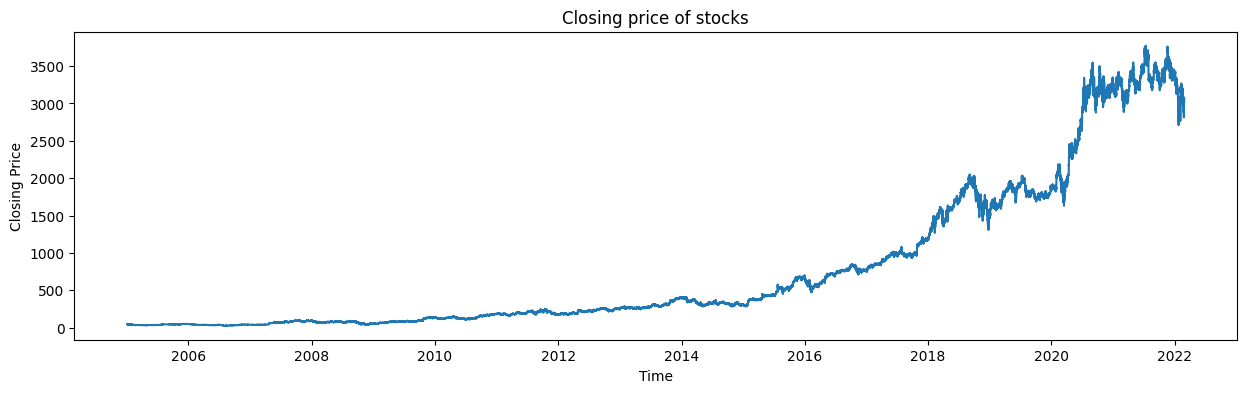

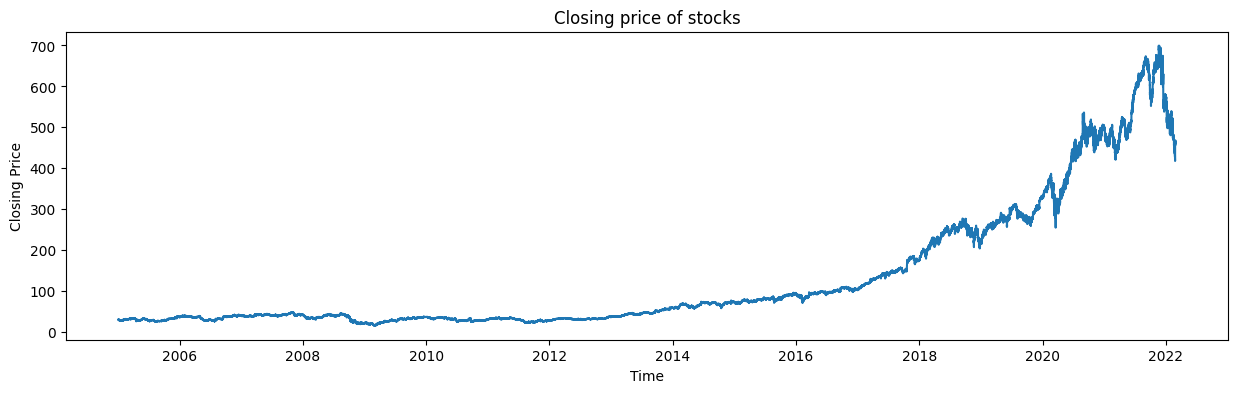

In [5]:
for i, stock_data in enumerate(stocks):
    plt.figure(figsize=(15, 4))
    plt.plot(stock_data.index, stock_data['close'])
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.title("Closing price of stocks")
    
    plt.show()

Visualizing the trends and seasonality in stock prices

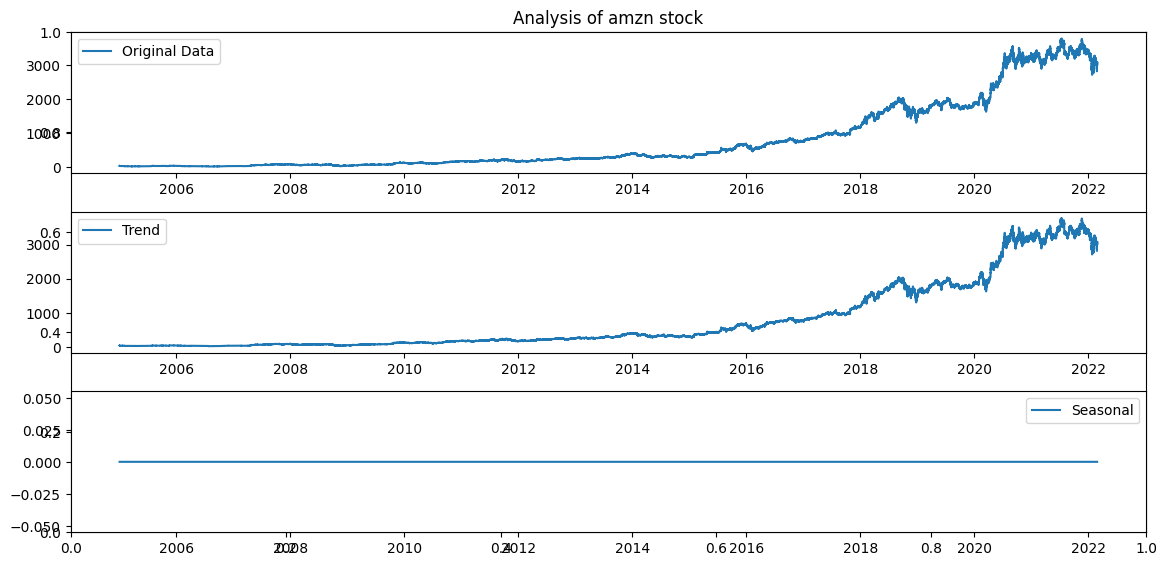

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(12, 6))
plt.title("Analysis of amzn stock")
plt.subplot(3, 1, 1)
plt.plot(stocks[0].index, stocks[0]['close'], label='Original Data')
plt.legend()

result = seasonal_decompose(stocks[0]['close'], model='additive', period=1)

plt.subplot(3, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.tight_layout()

plt.show()


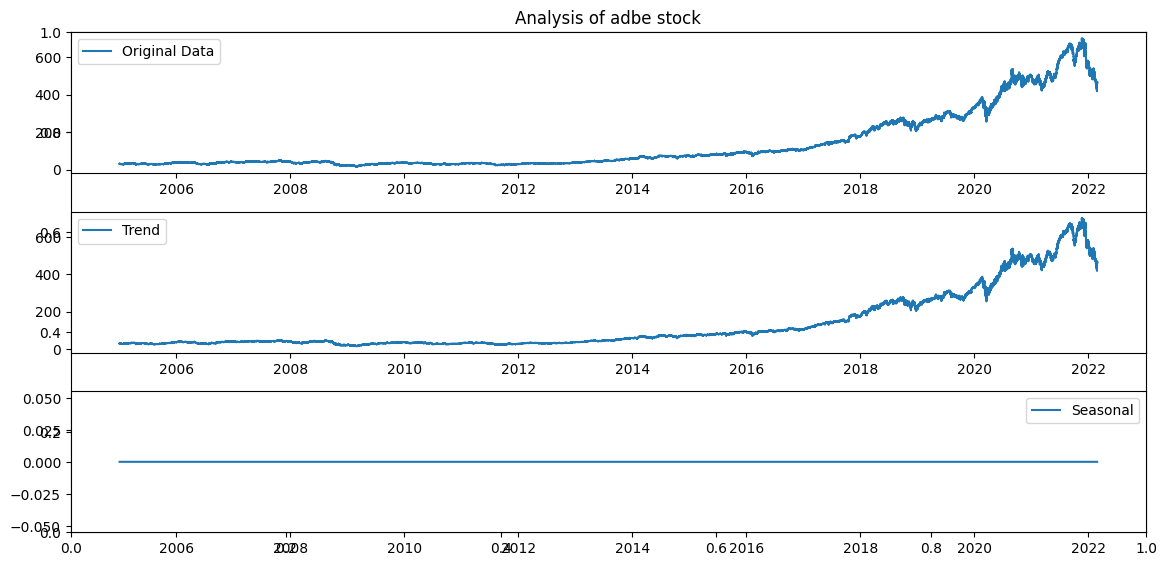

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(12, 6))
plt.title("Analysis of adbe stock")

plt.subplot(3, 1, 1)
plt.plot(stocks[1].index, stocks[1]['close'], label='Original Data')
plt.legend()

result = seasonal_decompose(stocks[1]['close'], model='additive', period=1)

plt.subplot(3, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.tight_layout()
plt.show()

Normalizing the data

In [8]:
from sklearn.preprocessing import MinMaxScaler


stock1_to_train = stocks[0].iloc[:8000, :]
stock1_n = MinMaxScaler(feature_range=(0, 1)).fit_transform(stock1_to_train)
stock1_n = pd.DataFrame(stock1_n)

stock2_to_train = stocks[1].iloc[:8000, :]
stock2_n=MinMaxScaler(feature_range=(0,1)).fit_transform(stock2_to_train)
stock2_n = pd.DataFrame(stock2_n)



Creating pytorch LSTM module based on RNN

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out



Creating custom dataloader class 

In [10]:
def dataloader(stock, insight, split):
    data_frame = stock.values
    df = []

    for i in range(stock.shape[0] - insight):
        df.append(data_frame[i:insight + i, :])

    df = np.array(df)
    test_set_size = int((1 - split) * df.shape[0])
    train_set_size = df.shape[0] - (test_set_size)

    x_train = df[:train_set_size, :-1, :]
    y_train = df[:train_set_size, -1, 3]

    x_test = df[train_set_size:, :-1, :]
    y_test = df[train_set_size:, -1, 3]

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)

    y_train = torch.from_numpy(y_train).type(torch.Tensor).reshape(-1, 1)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).reshape(-1, 1)

    return [x_train, y_train, x_test, y_test]

Selecting the parameters for the LSTM network after analyzing bias and variance.

In [11]:
input_dim = 5
hidden_dim = 256
num_layers = 2
output_dim = 1
batch_size = 40
learning_rate = 0.001
insight = 10
train_split = 0.8

Model compilation and Training
The loss function used is Mean squared error loss which is obvious in regression based predictions.
Adam optimizer is used which can modify its learning rate and minimizes the MSE loss efficiently.

In [12]:
x_train_stock1, y_train_stock1, x_test_stock1, y_test_stock1 = dataloader(stock1_n, insight, train_split)

#Model compilation
model1 = LSTM(input_dim, hidden_dim, num_layers,output_dim)
loss_fn = torch.nn.MSELoss()
optimiser_stock1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

n_epochs = 100
error = np.zeros(n_epochs)
seq_dim_stock1 = insight - 1

for t in range(n_epochs):
    y_train_pred_stock1 = model1(x_train_stock1)
    loss_stock1 = loss_fn(y_train_pred_stock1, y_train_stock1)

    if (t + 1) % 1 == 0 and t != 0:
        print("Epoch ", t , "LOSS: ", loss_stock1.item())
    error[t] = loss_stock1.item()

    optimiser_stock1.zero_grad()
    loss_stock1.backward()
    optimiser_stock1.step()




Epoch  1 LOSS:  0.1673176884651184
Epoch  2 LOSS:  0.11085257679224014
Epoch  3 LOSS:  0.062133386731147766
Epoch  4 LOSS:  0.0376342348754406
Epoch  5 LOSS:  0.07317571341991425
Epoch  6 LOSS:  0.06080763787031174
Epoch  7 LOSS:  0.03767407685518265
Epoch  8 LOSS:  0.03105836920440197
Epoch  9 LOSS:  0.033962540328502655
Epoch  10 LOSS:  0.03771976754069328
Epoch  11 LOSS:  0.03845283016562462
Epoch  12 LOSS:  0.0352296456694603
Epoch  13 LOSS:  0.02858230099081993
Epoch  14 LOSS:  0.02016712911427021
Epoch  15 LOSS:  0.013107837177813053
Epoch  16 LOSS:  0.011853200383484364
Epoch  17 LOSS:  0.01717466302216053
Epoch  18 LOSS:  0.017760520800948143
Epoch  19 LOSS:  0.010233226232230663
Epoch  20 LOSS:  0.0047030397690832615
Epoch  21 LOSS:  0.004812359344214201
Epoch  22 LOSS:  0.00723303435370326
Epoch  23 LOSS:  0.008295394480228424
Epoch  24 LOSS:  0.006570443511009216
Epoch  25 LOSS:  0.003068478312343359
Epoch  26 LOSS:  0.0009542381740175188
Epoch  27 LOSS:  0.00315129710361361

Plotting the loss as a function of epochs suggest the loss has been converged after approximately 40 epochs.

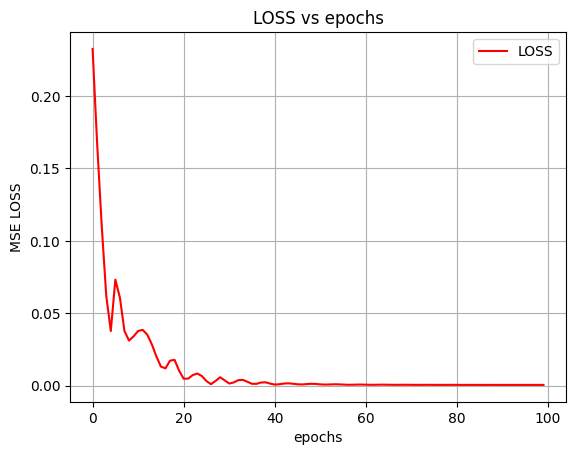

In [13]:
plt.plot(error,color="red", label="LOSS")
plt.ylabel("MSE LOSS")
plt.xlabel("epochs")
plt.title("LOSS vs epochs")
plt.grid()
plt.legend()


First Making prediction on training set suggest my model has fit well into the training data.

Text(0.5, 1.0, 'Predictions on training set')

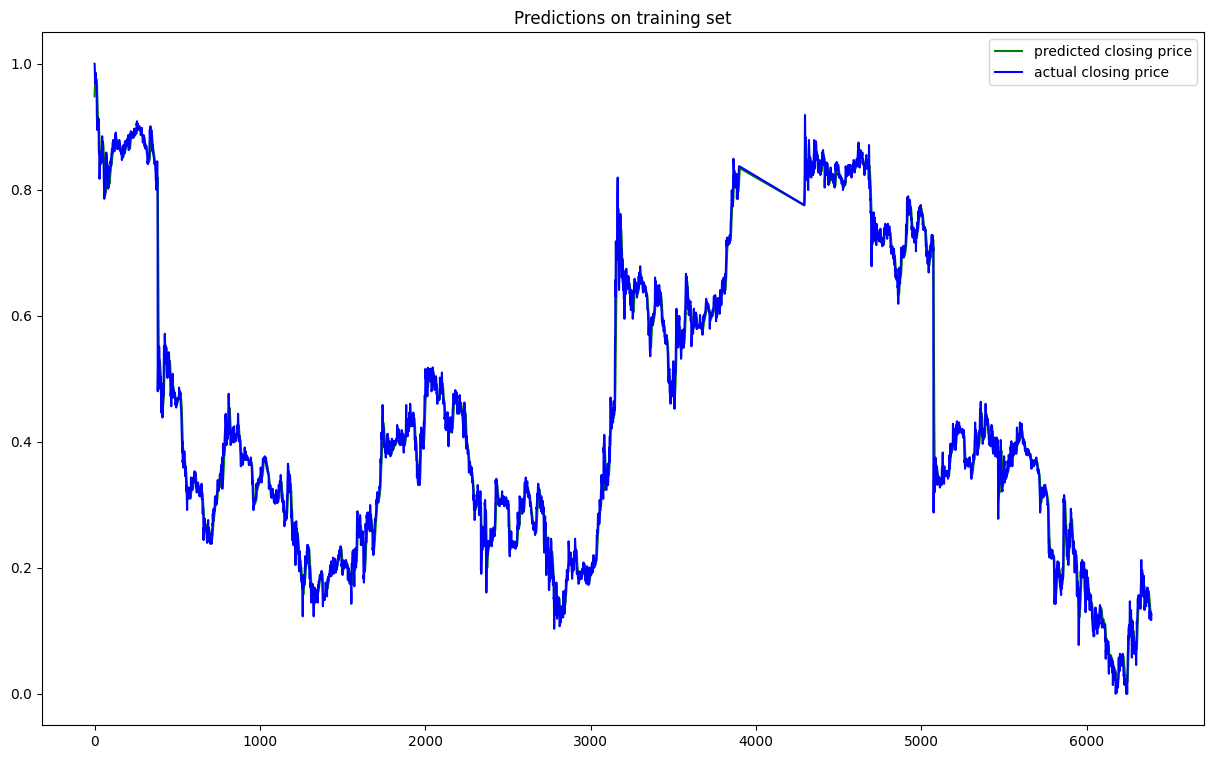

In [14]:
y_train_pred= model1(x_train_stock1)

plt.figure(figsize=(15, 9))  
plt.plot(y_train_pred.detach().numpy(), color="green",label="predicted closing price")
plt.plot(y_train_stock1, color="blue", label="actual closing price")
plt.legend()
plt.title("Predictions on training set")


Predicting the model on test data

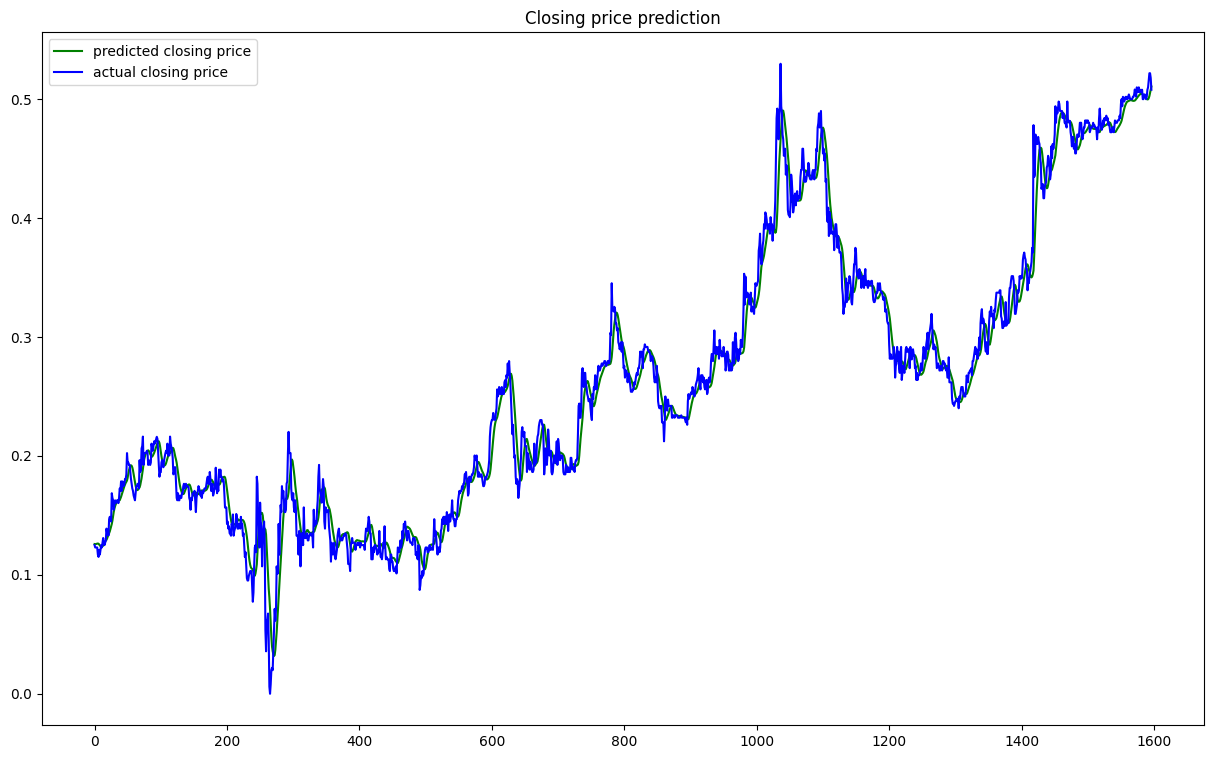

MSE LOSS on test_data is: 0.000270139


In [15]:
y_test_pred = model1(x_test_stock1)

plt.figure(figsize=(15,9))
plt.plot(y_test_pred.detach().numpy(), color = 'green', label ='predicted closing price')
plt.plot(y_test_stock1, color = 'blue', label ='actual closing price')
plt.title('Closing price prediction')
plt.legend()
plt.show()

print("MSE LOSS on test_data is:", loss_fn(y_test_pred,y_test_stock1).detach().numpy())



Making the model for second stock adbe

In [16]:
#Tuning the parameters based on bias and variance for second stock
input_dim = 5
hidden_dim = 256
num_layers = 2
output_dim = 1
batch_size = 40
learning_rate = 0.001
insight = 10
train_split = 0.8


x_train_stock2, y_train_stock2, x_test_stock2, y_test_stock2 = dataloader(stock2_n, insight, train_split)

#Model compilation
model2 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)
loss_fn = torch.nn.MSELoss()
optimiser_stock2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

n_epochs = 100
error2 = np.zeros(n_epochs)

seq_dim_stock2 = insight - 1
for t in range(n_epochs):
    y_train_pred_stock2 = model2(x_train_stock2)
    loss_stock2 = loss_fn(y_train_pred_stock2, y_train_stock2)

    if (t + 1) % 1 == 0 and t != 0:
        print("Epoch ", t , "LOSS: ", loss_stock1.item())
    error2[t] = loss_stock2.item()

    optimiser_stock2.zero_grad()
    loss_stock2.backward()
    optimiser_stock2.step()

Epoch  1 LOSS:  0.00042346614645794034
Epoch  2 LOSS:  0.00042346614645794034
Epoch  3 LOSS:  0.00042346614645794034
Epoch  4 LOSS:  0.00042346614645794034
Epoch  5 LOSS:  0.00042346614645794034
Epoch  6 LOSS:  0.00042346614645794034
Epoch  7 LOSS:  0.00042346614645794034
Epoch  8 LOSS:  0.00042346614645794034
Epoch  9 LOSS:  0.00042346614645794034
Epoch  10 LOSS:  0.00042346614645794034
Epoch  11 LOSS:  0.00042346614645794034
Epoch  12 LOSS:  0.00042346614645794034
Epoch  13 LOSS:  0.00042346614645794034
Epoch  14 LOSS:  0.00042346614645794034
Epoch  15 LOSS:  0.00042346614645794034
Epoch  16 LOSS:  0.00042346614645794034
Epoch  17 LOSS:  0.00042346614645794034
Epoch  18 LOSS:  0.00042346614645794034
Epoch  19 LOSS:  0.00042346614645794034
Epoch  20 LOSS:  0.00042346614645794034
Epoch  21 LOSS:  0.00042346614645794034
Epoch  22 LOSS:  0.00042346614645794034
Epoch  23 LOSS:  0.00042346614645794034
Epoch  24 LOSS:  0.00042346614645794034
Epoch  25 LOSS:  0.00042346614645794034
Epoch  26

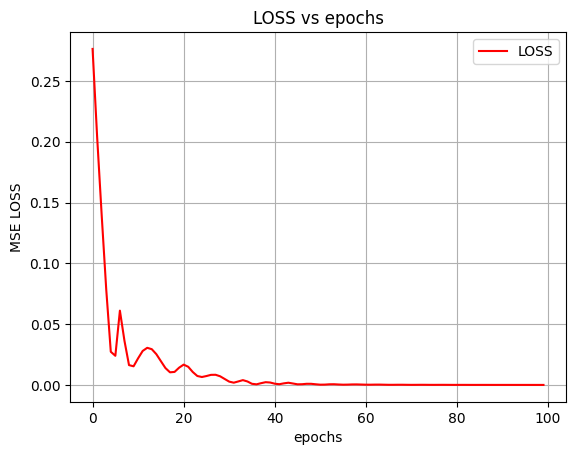

In [17]:
plt.plot(error2,color="red", label="LOSS")
plt.ylabel("MSE LOSS")
plt.xlabel("epochs")
plt.title("LOSS vs epochs")
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Predictions on training set')

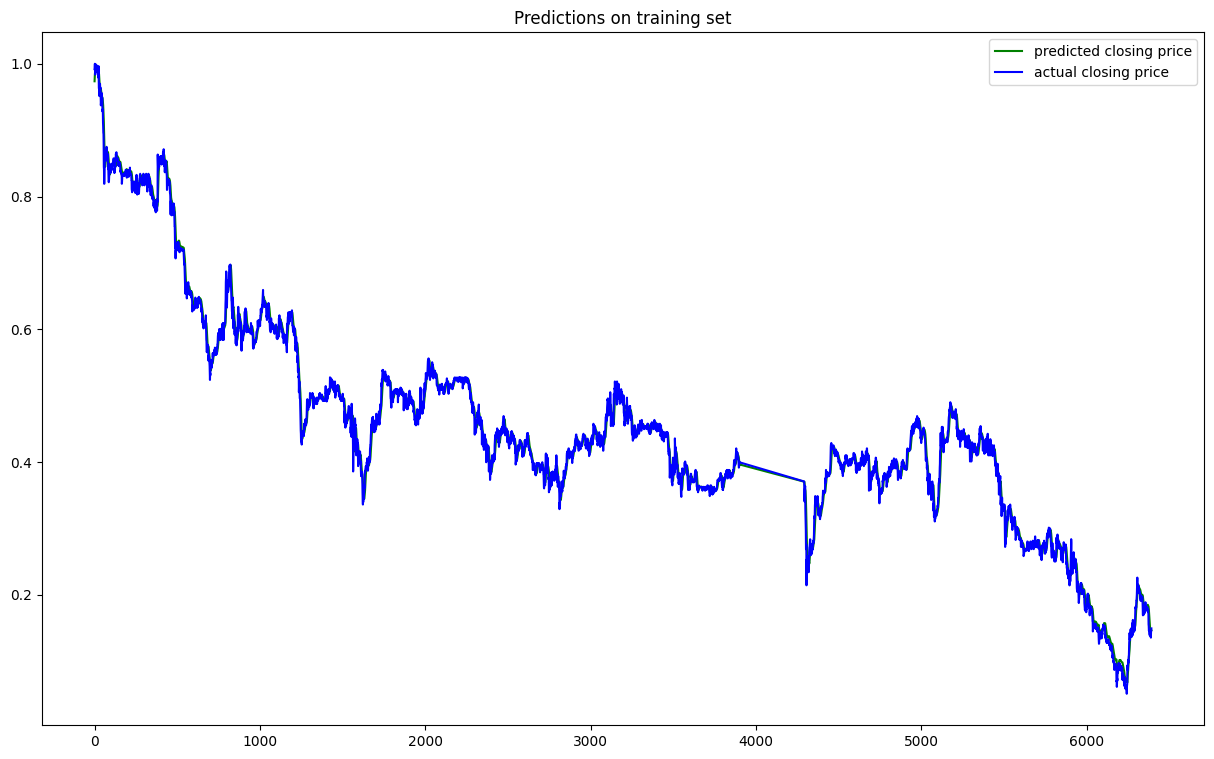

In [18]:
y_train_pred2= model2(x_train_stock2)

plt.figure(figsize=(15, 9))  
plt.plot(y_train_pred2.detach().numpy(), color="green",label="predicted closing price")
plt.plot(y_train_stock2, color="blue", label="actual closing price")
plt.legend()
plt.title("Predictions on training set")

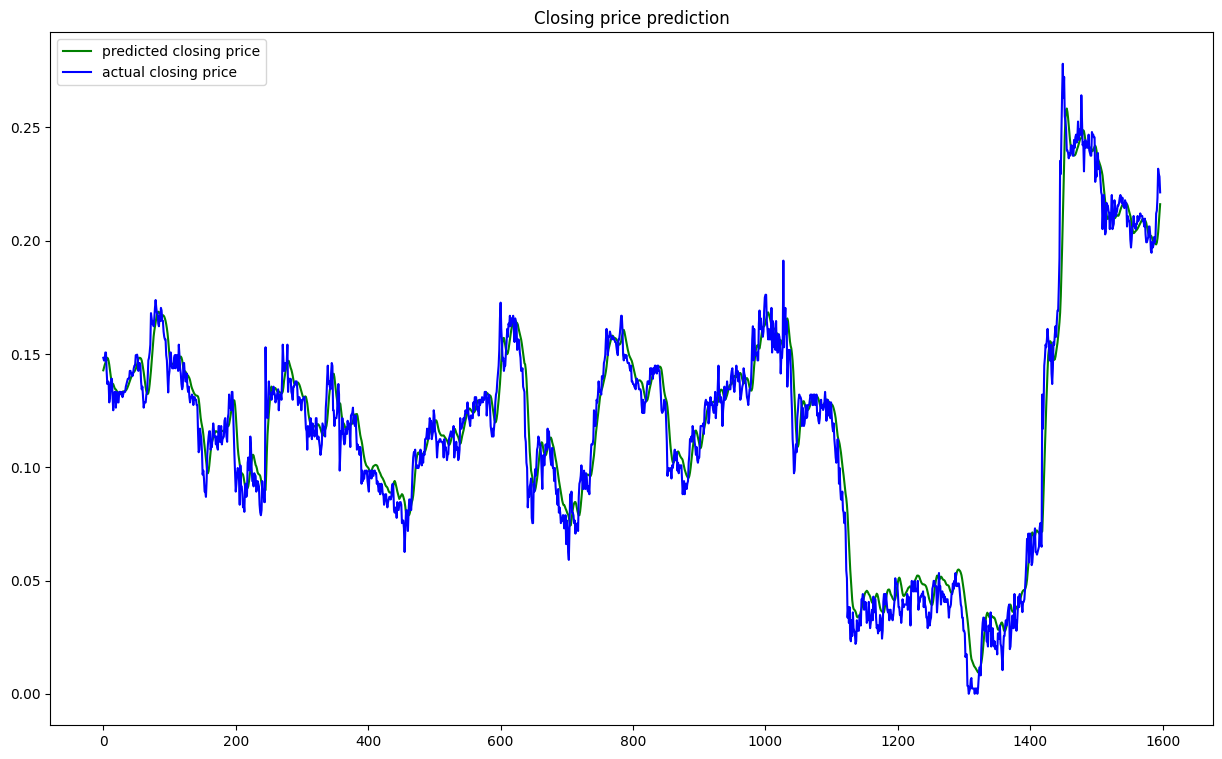

MSE LOSS on test_data is: 0.000114741444


In [19]:
y_test_pred2 = model1(x_test_stock2)

plt.figure(figsize=(15,9))
plt.plot(y_test_pred2.detach().numpy(), color = 'green', label ='predicted closing price')
plt.plot(y_test_stock2, color = 'blue', label ='actual closing price')
plt.title('Closing price prediction')
plt.legend()
plt.show()
print("MSE LOSS on test_data is:", loss_fn(y_test_pred2,y_test_stock2).detach().numpy())



Some Trading Strategies that could be utilised....

In [ ]:
import torch.nn.functional as F

def ema_signal(data, short_window=12, long_window=26):
    close_prices = data.view(-1)
    short_ema = close_prices.unfold(0, short_window, 1).mean(dim=-1)
    long_ema = close_prices.unfold(0, long_window, 1).mean(dim=-1)


    signals = torch.zeros_like(close_prices)
    signals[short_window:] = torch.where(short_ema > long_ema[:-short_window+1], 1.0, 0.0)
    positions = signals - torch.roll(signals, 1)

    return signals, positions




def prediction_signal(predictions):
    signals = torch.zeros_like(predictions)
    signals[predictions > 0] = 1.0  # Buy when positive prediction
    signals[predictions < 0] = -1.0  # Sell when negative prediction
    positions = signals - torch.roll(signals, 1)

    return signals, positions

In [21]:
def trading_strategy(data_frame, date, indicator_values):
    data_frame['indicator_values'] = np.nan    
    data_frame['indicator_values'][data_frame.shape[0]-indicator_values.shape[0]:] = indicator_values


    selected_data = data_frame[data_frame['index'].dt.date == date]

    
    action = 'x'
    profit_actual = 0    
    prev_price = 0
    first_investment = 0
    
    buy_signals = np.nan * np.zeros(selected_data.shape[0])    
    sell_signals = np.nan * np.zeros(selected_data.shape[0])
    buy_signals_actual = np.nan * np.zeros(selected_data.shape[0])
    sell_signals_actual = np.nan * np.zeros(selected_data.shape[0])

    selected_data = selected_data.reset_index()

    for i in range(1, selected_data.shape[0]):
        current_price = selected_data['close'][i-1]
        current_indicator = selected_data['indicator_values'][i]

        
        if current_indicator > 0.8:
            action = 'Buy'
            buy_signals[i] = current_price    
            buy_signals_actual[i] = selected_data['close'][i]    
            
            prev_price = selected_data['close'][i]    
            
            if first_investment == 0:
                first_investment = selected_data['close'][i]

        
        elif current_indicator < 0.2 and action == 'Buy':
            action = 'Sell'
            sell_signals[i] = current_price   
            sell_signals_actual[i] = selected_data['close'][i]    
            profit_actual = profit_actual + selected_data['close'][i] - prev_price

        
        else:
            action = 'Hold'

    roi = profit_actual * 100 / first_investment  

    
    plt.figure(figsize=(12, 5))
    plt.plot(selected_data.index, selected_data['close'], label='Actual Close',)
    plt.scatter(selected_data.index, buy_signals, marker='^', color='green', label='Buy Signal', s=20)
    plt.scatter(selected_data.index, sell_signals, marker='v', color='red', label='Sell Signal', s=20)
    plt.xlabel('Timestamp')
    plt.ylabel('Closing Price')
    plt.title('Another Trading Strategy')
    plt.legend()
    plt.show()
    
    
    print(f"Initial Balance: ${first_investment:.2f}")
    print(f"Final Balance: ${profit_actual+first_investment:.2f}")
    print(f"Final Profit: ${profit_actual:.2f}")
    print(f"Returns: {roi:.2f}%")
    print()
